# Conditional Variational Autoencoder with Pytorch

Only decoder receives condition in this version.

In [42]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from tqdm import tqdm

In [3]:
def onehot(x, max_dim):
    'batch_size, -> batch_size, max_dim'
    batch_size = x.shape[0]
    vector = torch.zeros(batch_size, max_dim).to(x.device)
    for i in range(batch_size):
        vector[i,x[i]] = 1
    return vector

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.linear = torch.nn.Linear(input_size, hidden_size)
        self.mu = torch.nn.Linear(hidden_size, latent_size)
        self.sigma = torch.nn.Linear(hidden_size, latent_size)
    def forward(self, x):
        x = F.relu(self.linear(x)) 
        mu = self.mu(x) 
        sigma = self.sigma(x)
        return mu,sigma
    
class Decoder(torch.nn.Module):
    def __init__(self, latent_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(latent_size, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, output_size)
    def forward(self, x): 
        x = F.relu(self.linear1(x)) 
        x = torch.sigmoid(self.linear2(x)) 
        return x
    
class CVAE(torch.nn.Module):
    def __init__(self, input_size, output_size, condition_size,
                 latent_size, hidden_size):
        super(CVAE, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, latent_size)
        self.decoder = Decoder(latent_size + condition_size, 
                               hidden_size, output_size)
    def forward(self, x, c): 
        # The difference here is that we don't concatenate input for encoder with condition c
        mu,sigma = self.encoder(x) 
        eps = torch.randn_like(sigma)  # sampling to generate new sample
        z = mu + eps * sigma  
        z = torch.cat((z,c),dim = 1) # z now has shape (batch_size, latent_size + condition_size)
        re_x = self.decoder(z) # reconstructed x has shape: (batch_size, output_size)
        return re_x,mu,sigma

In [5]:
loss_BCE = torch.nn.BCELoss(reduction = 'sum')
loss_MSE = torch.nn.MSELoss(reduction = 'sum')
loss_KLD = lambda mu,sigma: -0.5 * torch.sum(1 + torch.log(sigma**2) - mu.pow(2) - sigma**2)

In [6]:
latent_size = 16 
hidden_size = 128 
input_size= output_size = 28*28 
condition_size = 10 

epochs = 10
batch_size = 32 
learning_rate = 3e-3 
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
modelname = 'cvae-variant.pth'
model = CVAE(input_size,output_size,condition_size,latent_size,hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
try:
    model.load_state_dict(torch.load(modelname))
    print('[INFO] Load Model complete')
except:
    pass

/var/folders/zx/j5d_p2_s2wz05zg3b78717100000gn/T/ipykernel_45404/423768807.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelname))


In [8]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 10.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 352kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.7MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Model Training

[train]epoch:0: 100%|██████████| 1875/1875 [00:08<00:00, 228.75it/s]


epoch:0|TrainLoss:  154.5083124267578


[eval]epoch:0: 100%|██████████| 313/313 [00:00<00:00, 420.27it/s]


epoch:0|Test Loss:  151.59267502441406


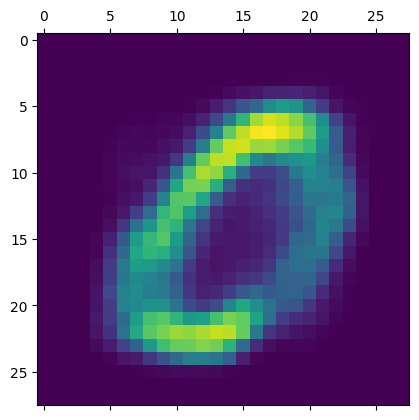

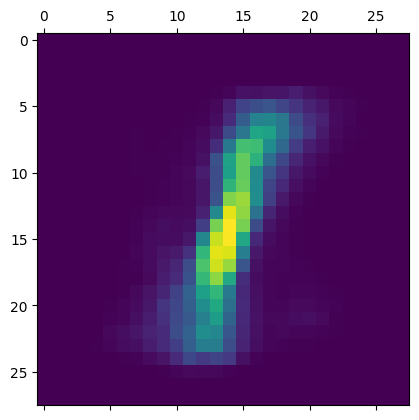

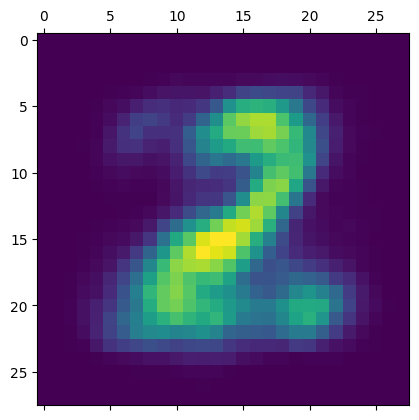

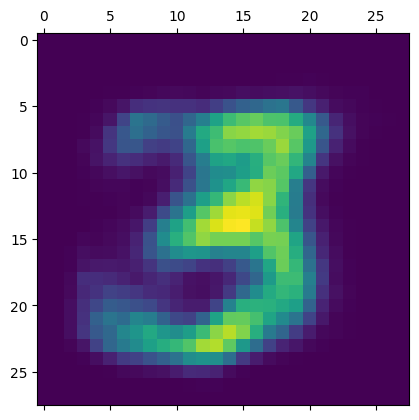

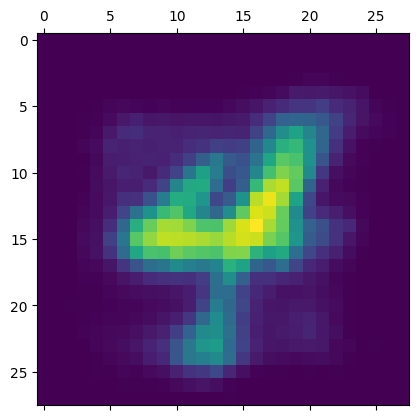

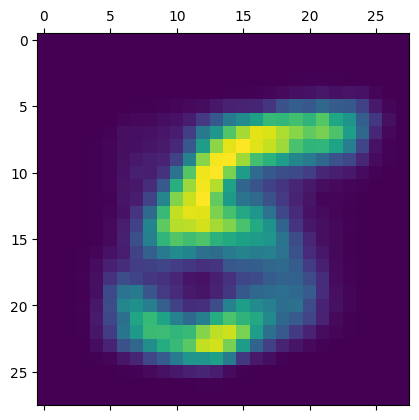

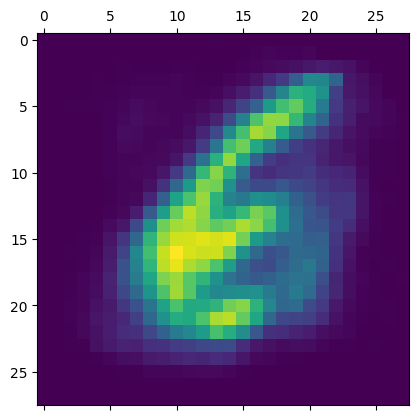

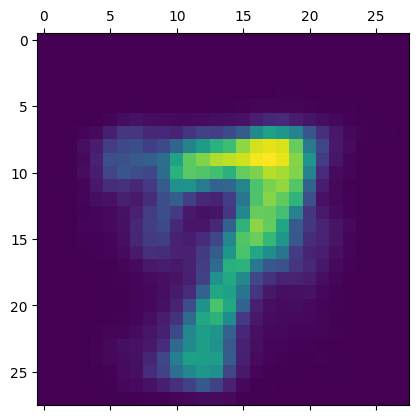

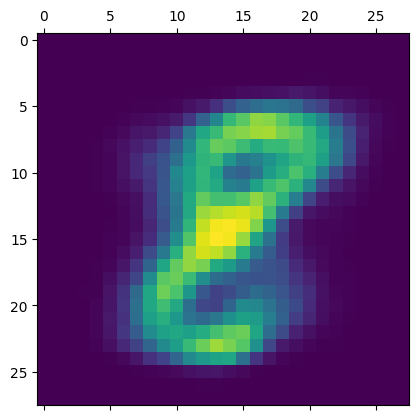

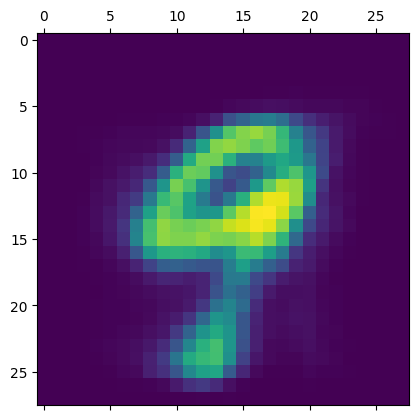

[train]epoch:1: 100%|██████████| 1875/1875 [00:13<00:00, 141.01it/s]


epoch:1|TrainLoss:  161.71815950520832


[eval]epoch:1: 100%|██████████| 313/313 [00:00<00:00, 313.09it/s]


epoch:1|Test Loss:  157.95143464355468


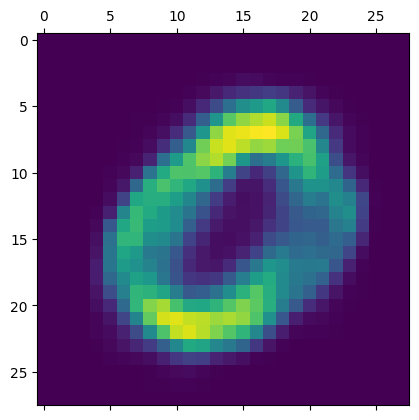

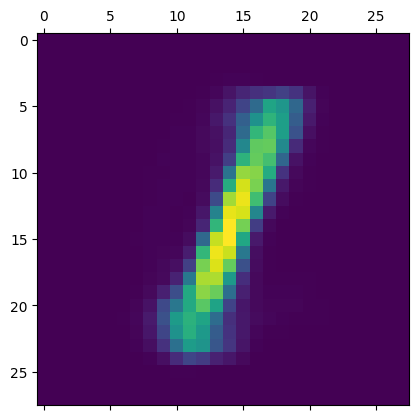

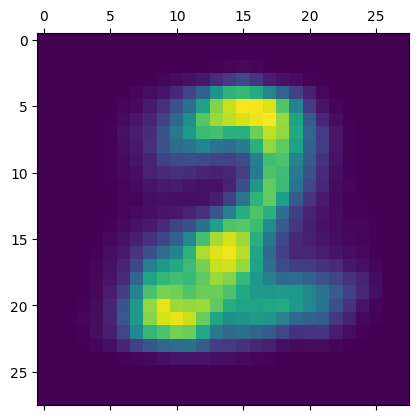

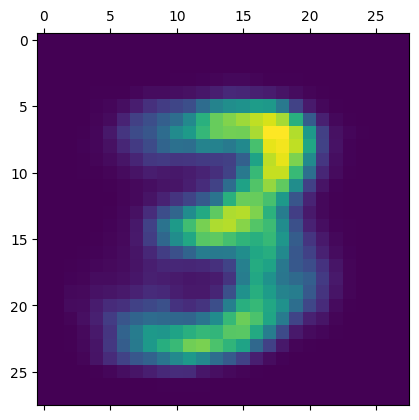

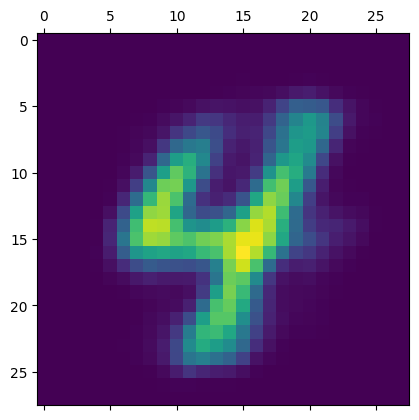

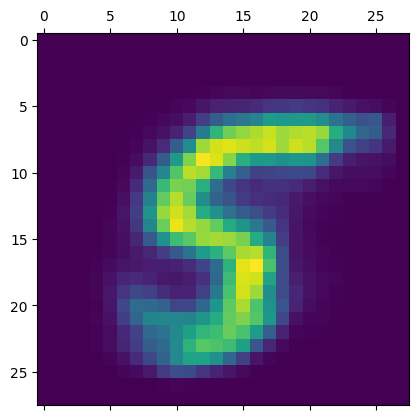

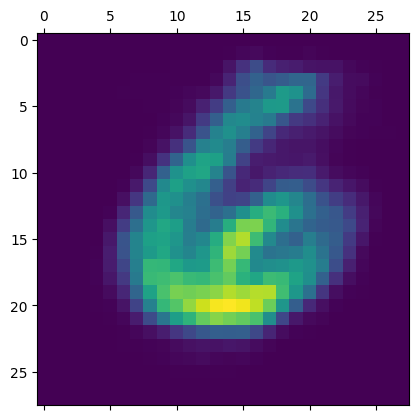

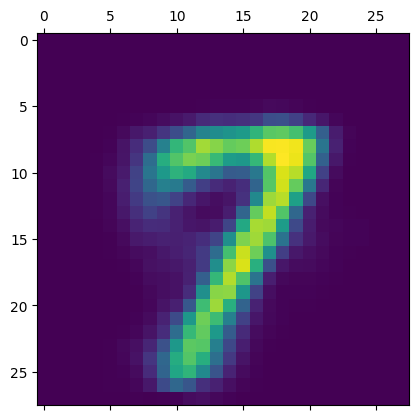

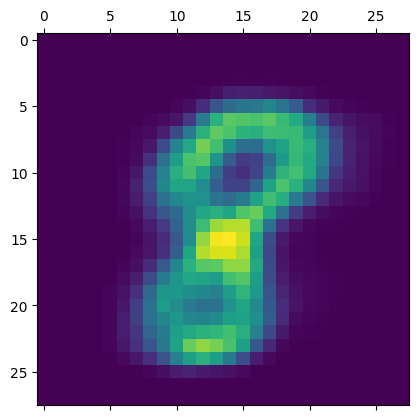

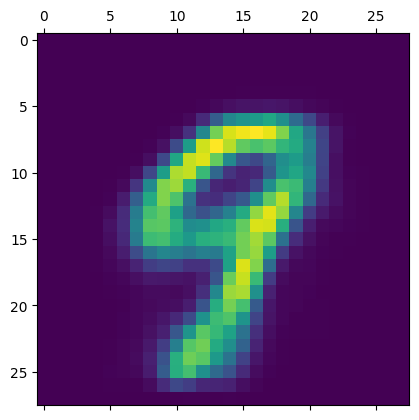

[train]epoch:2: 100%|██████████| 1875/1875 [00:09<00:00, 189.25it/s]


epoch:2|TrainLoss:  170.42717268066406


[eval]epoch:2: 100%|██████████| 313/313 [00:00<00:00, 429.74it/s]

epoch:2|Test Loss:  169.00453208007812


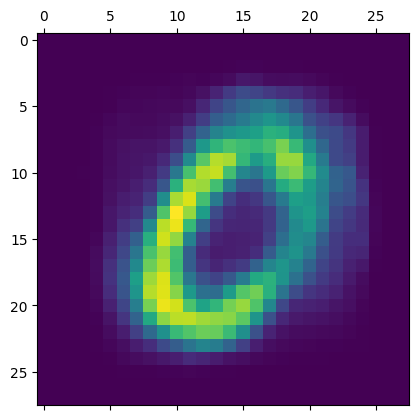

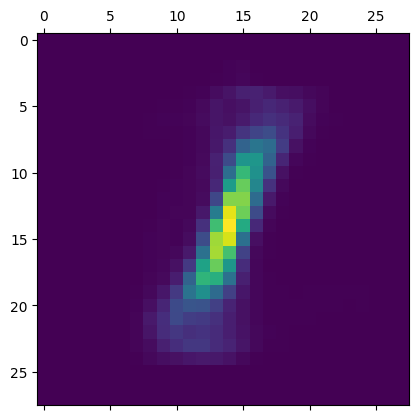

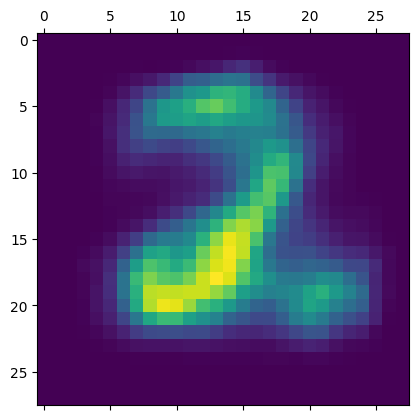

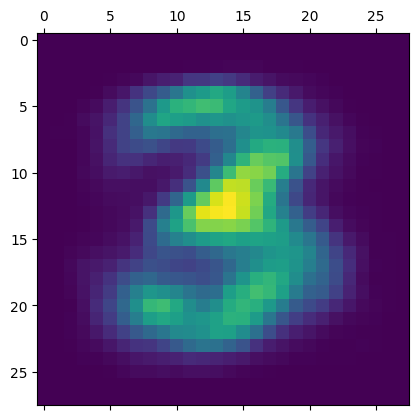

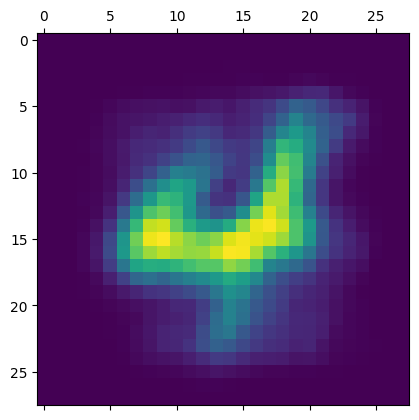

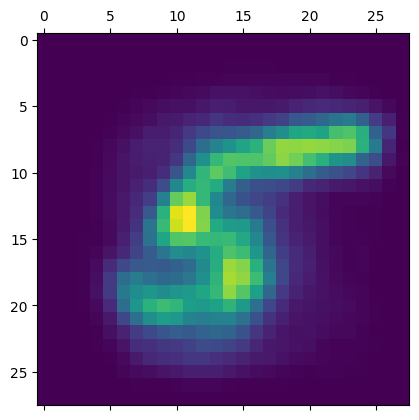

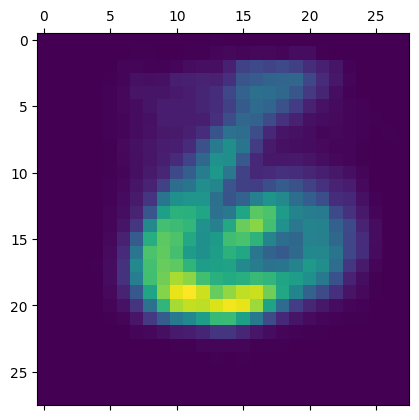

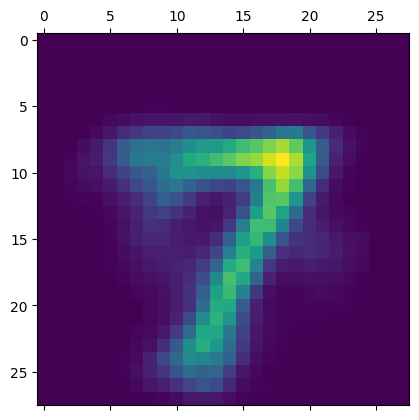

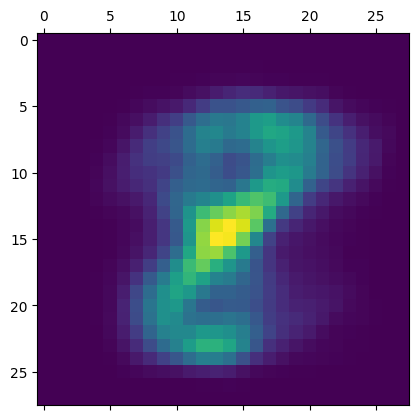

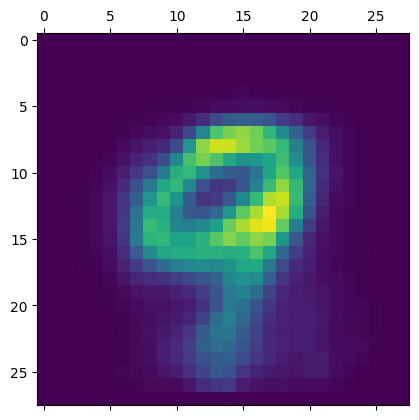

[train]epoch:3: 100%|██████████| 1875/1875 [00:07<00:00, 263.92it/s]


epoch:3|TrainLoss:  169.91578986816407


[eval]epoch:3: 100%|██████████| 313/313 [00:00<00:00, 433.38it/s]

epoch:3|Test Loss:  164.66742822265624


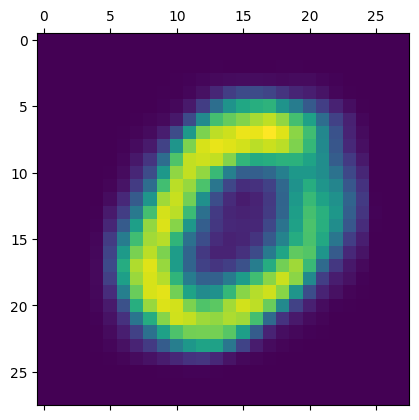

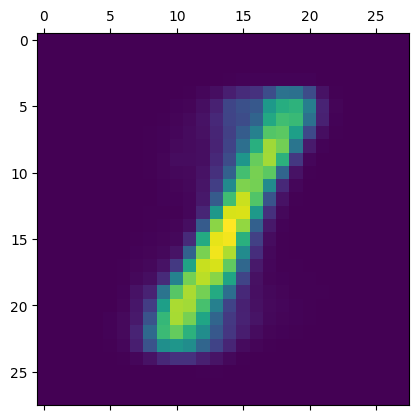

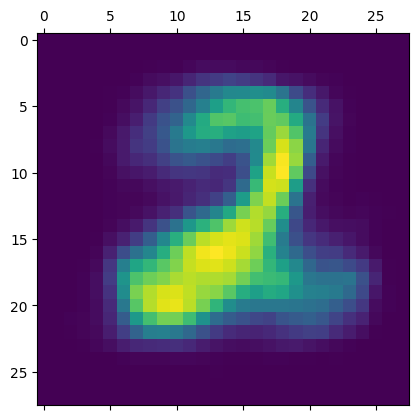

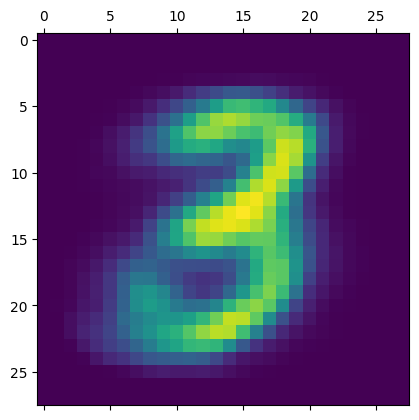

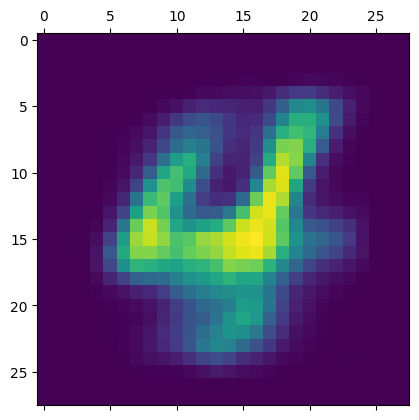

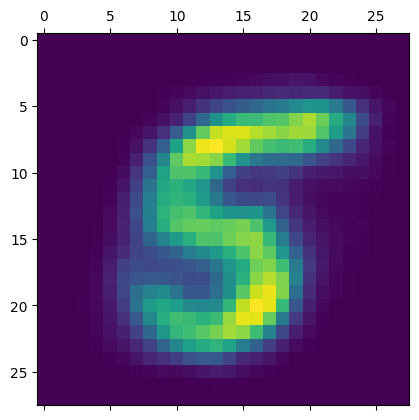

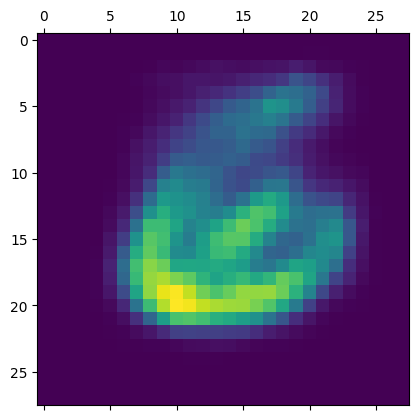

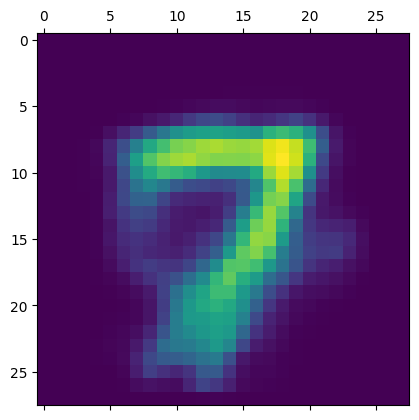

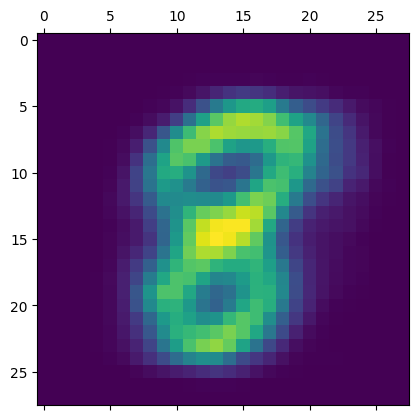

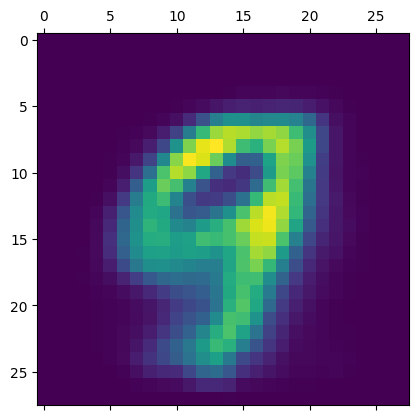

[train]epoch:4: 100%|██████████| 1875/1875 [00:07<00:00, 261.09it/s]


epoch:4|TrainLoss:  166.4420405517578


[eval]epoch:4: 100%|██████████| 313/313 [00:00<00:00, 399.22it/s]


epoch:4|Test Loss:  172.72436420898438


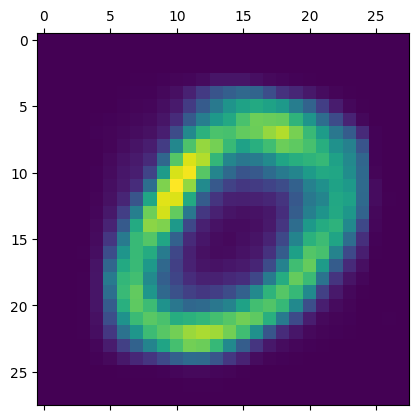

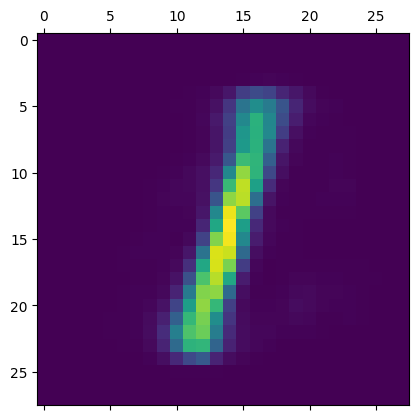

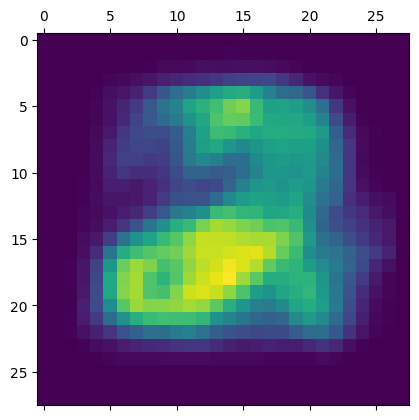

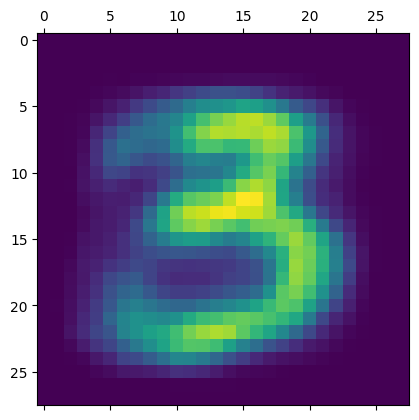

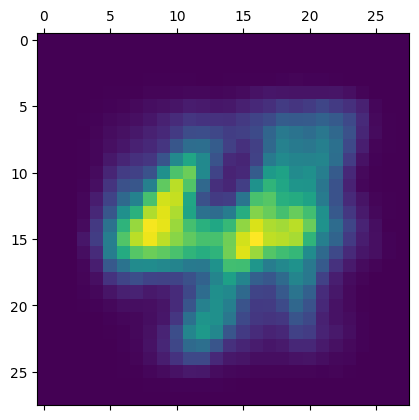

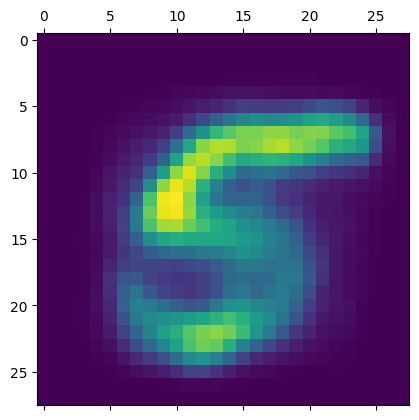

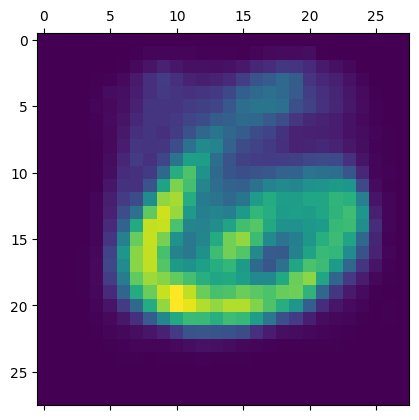

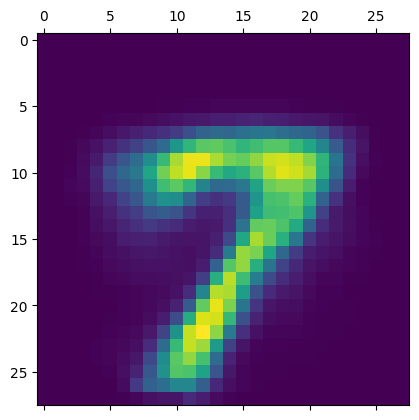

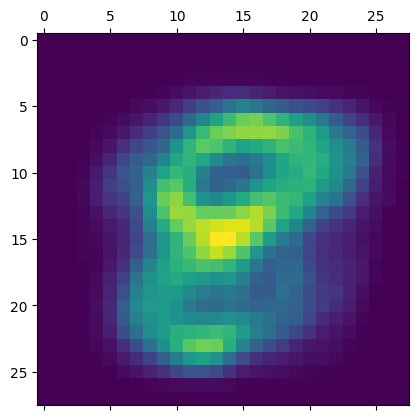

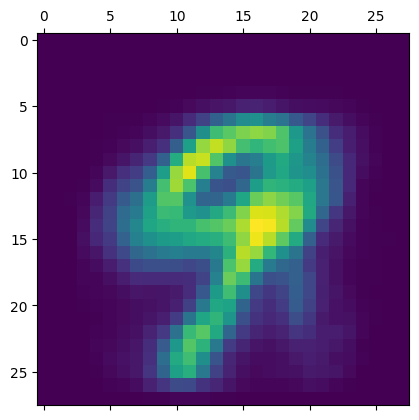

[train]epoch:5: 100%|██████████| 1875/1875 [00:07<00:00, 257.43it/s]


epoch:5|TrainLoss:  163.91764881998697


[eval]epoch:5: 100%|██████████| 313/313 [00:00<00:00, 426.25it/s]


epoch:5|Test Loss:  158.22740283203126


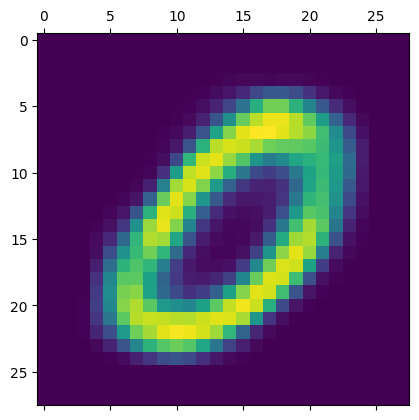

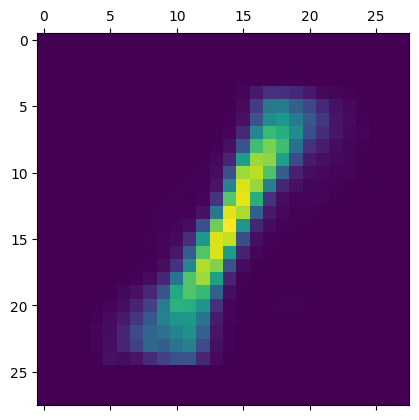

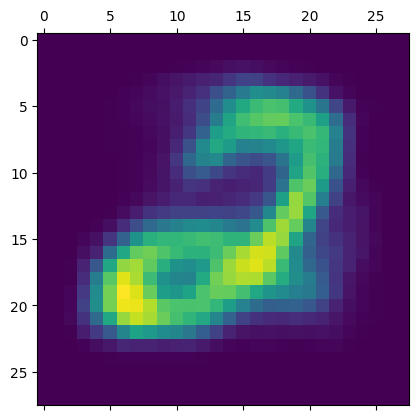

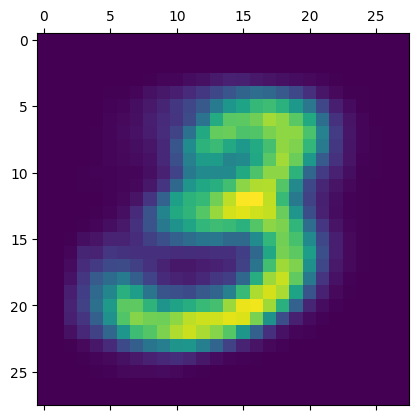

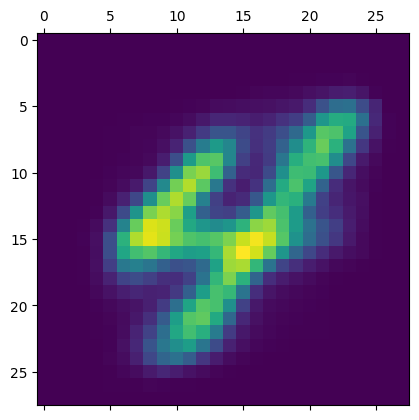

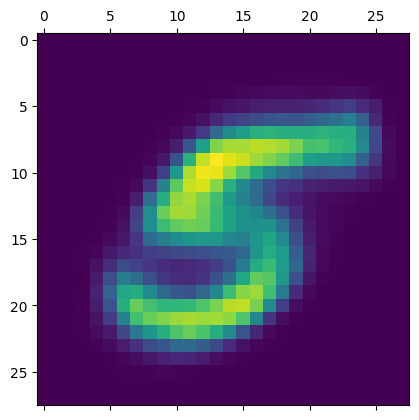

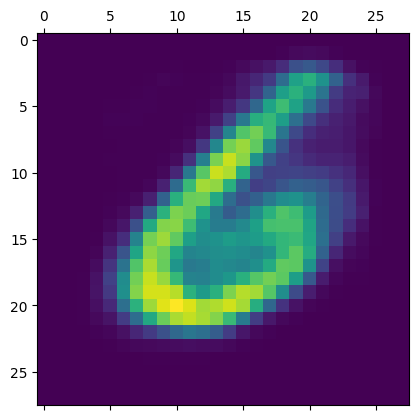

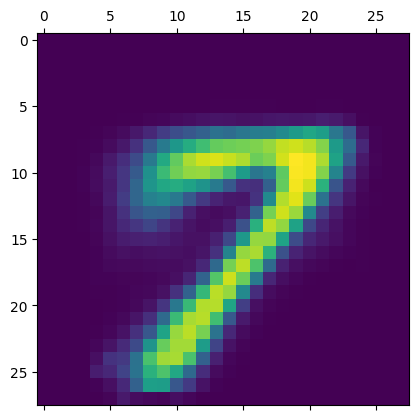

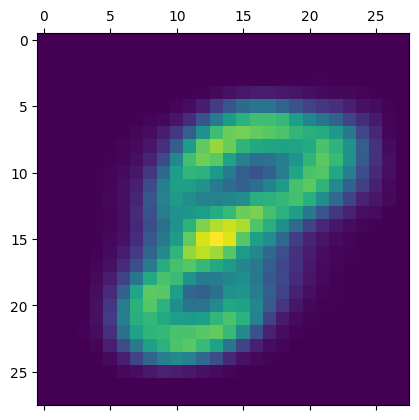

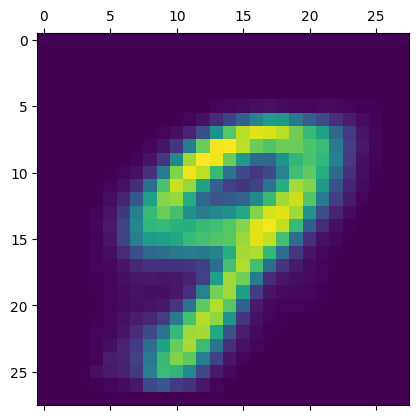

[train]epoch:6: 100%|██████████| 1875/1875 [00:07<00:00, 246.98it/s]


epoch:6|TrainLoss:  165.57254889322917


[eval]epoch:6: 100%|██████████| 313/313 [00:00<00:00, 363.03it/s]


epoch:6|Test Loss:  166.15983134765625


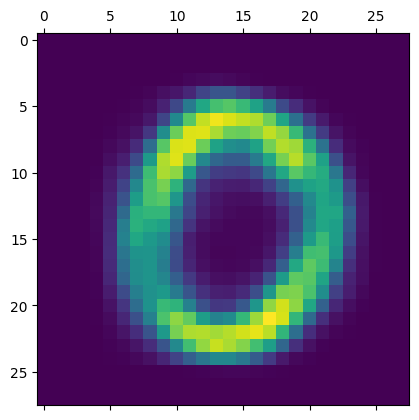

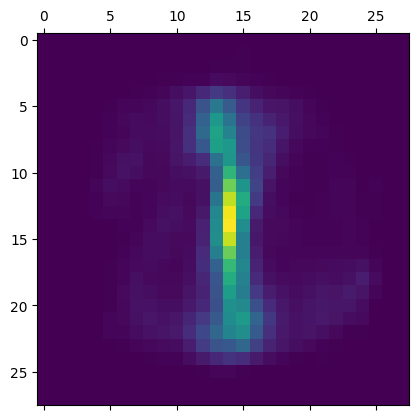

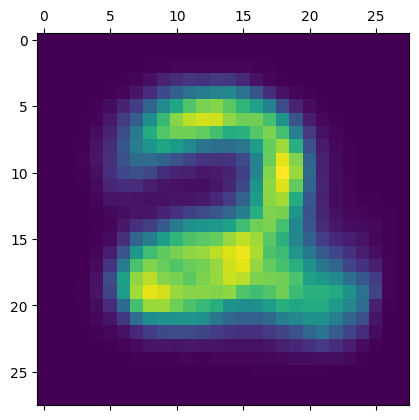

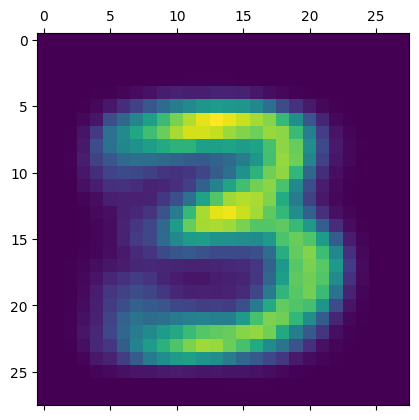

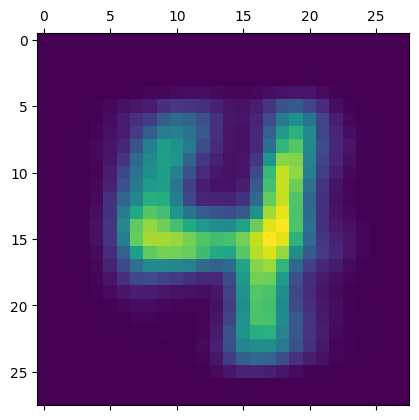

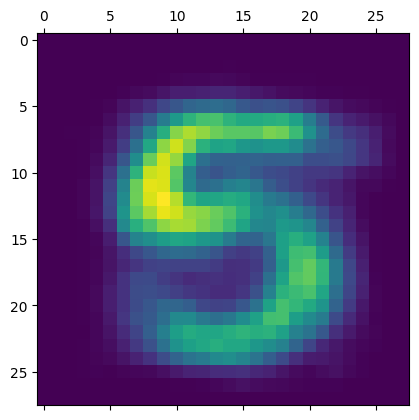

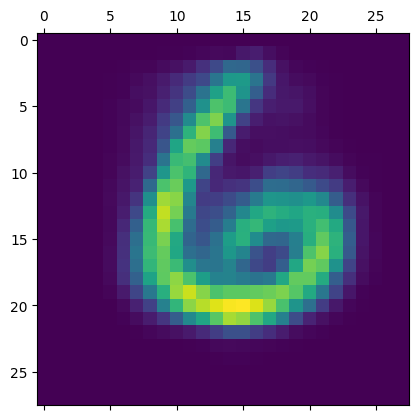

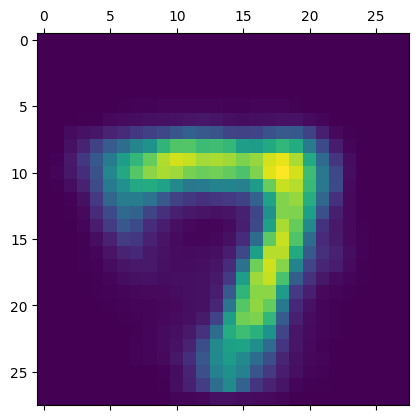

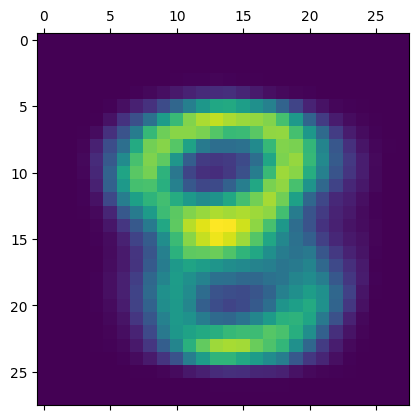

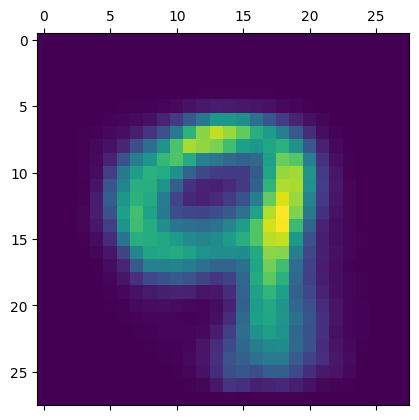

[train]epoch:7: 100%|██████████| 1875/1875 [00:13<00:00, 138.91it/s]


epoch:7|TrainLoss:  166.13900779622395


[eval]epoch:7: 100%|██████████| 313/313 [00:00<00:00, 356.00it/s]


epoch:7|Test Loss:  160.9447438232422


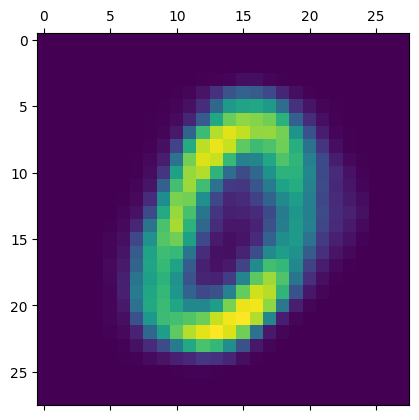

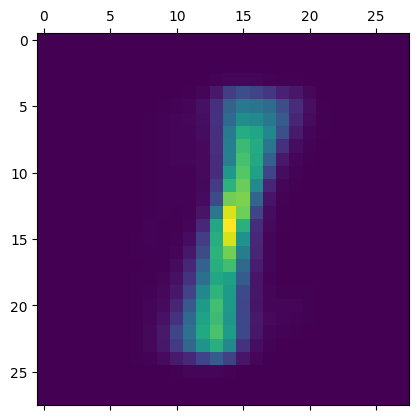

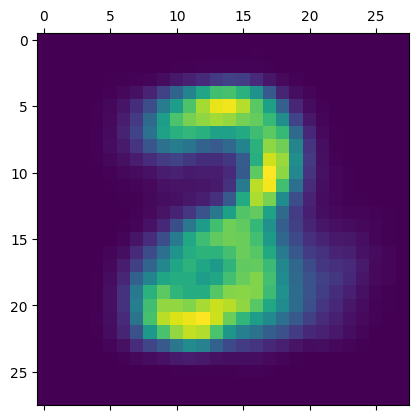

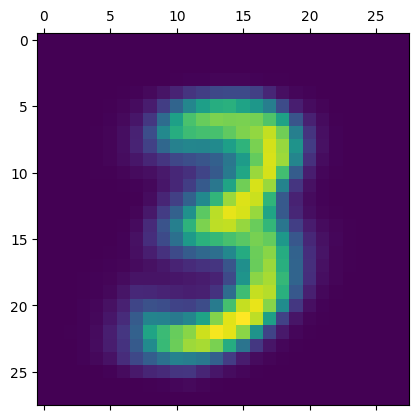

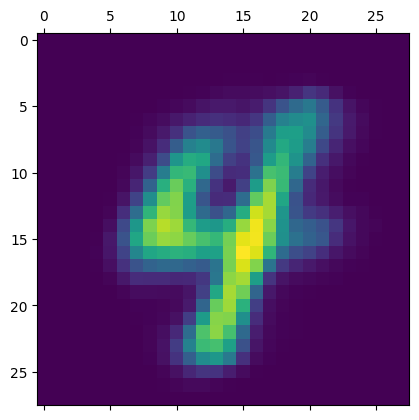

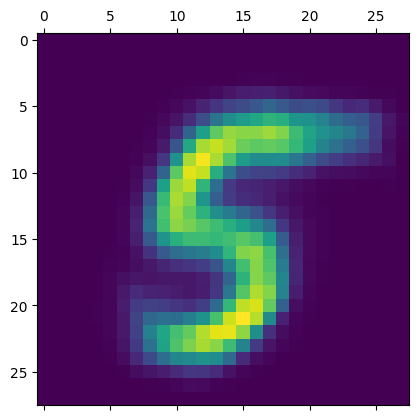

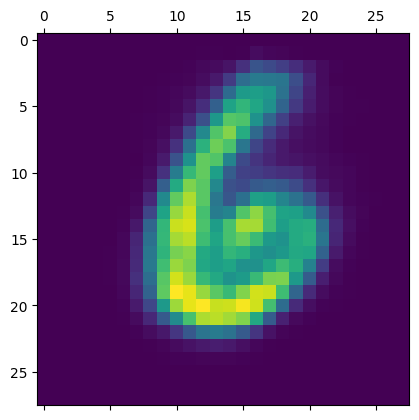

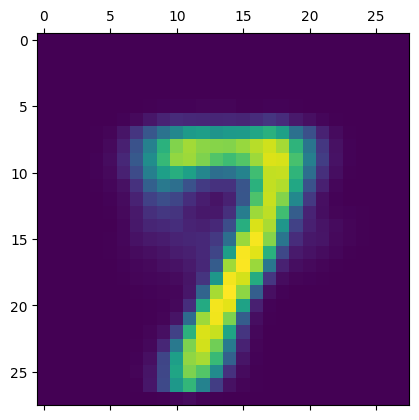

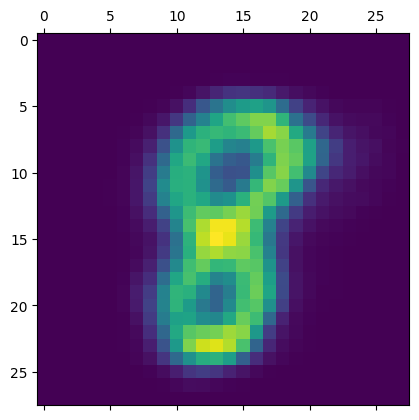

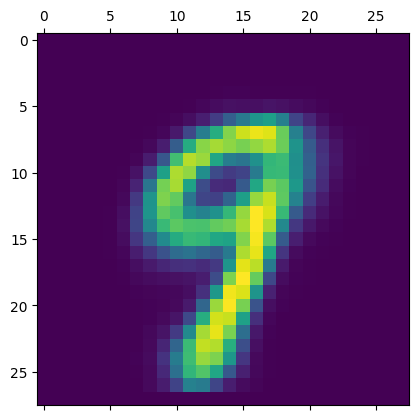

[train]epoch:8: 100%|██████████| 1875/1875 [00:09<00:00, 202.25it/s]


epoch:8|TrainLoss:  162.5825950358073


[eval]epoch:8: 100%|██████████| 313/313 [00:00<00:00, 442.19it/s]

epoch:8|Test Loss:  163.8354895751953


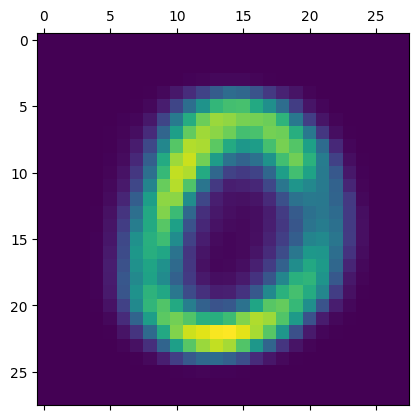

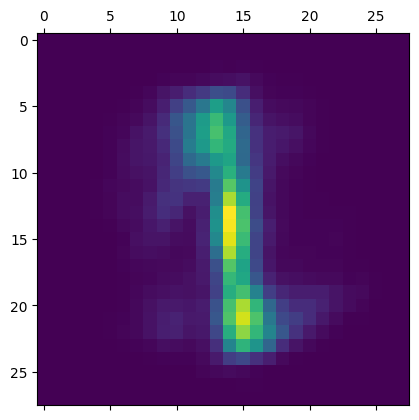

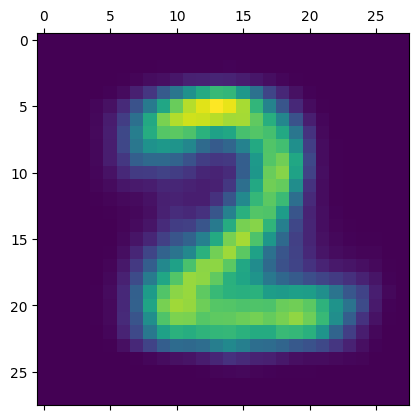

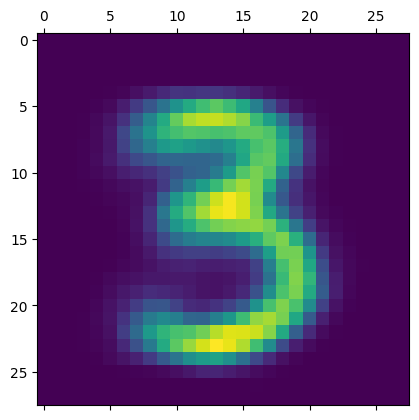

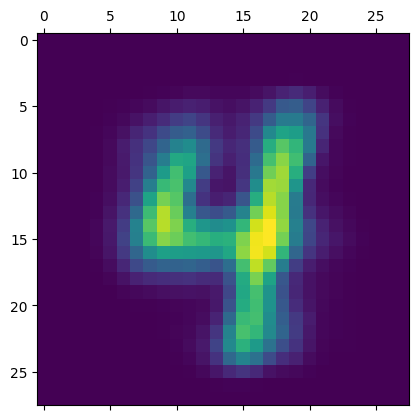

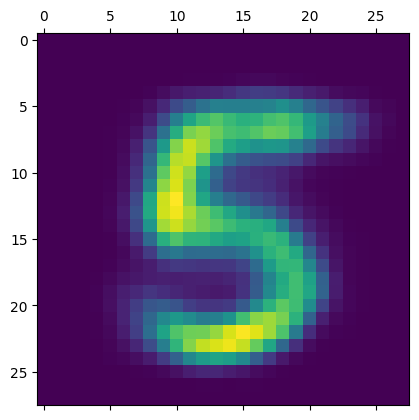

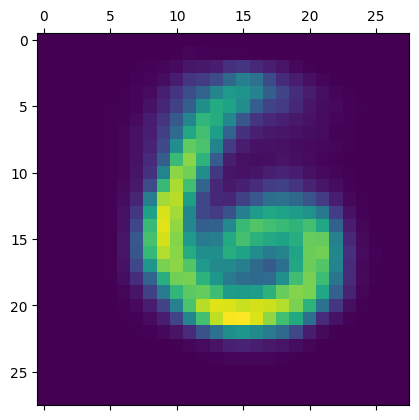

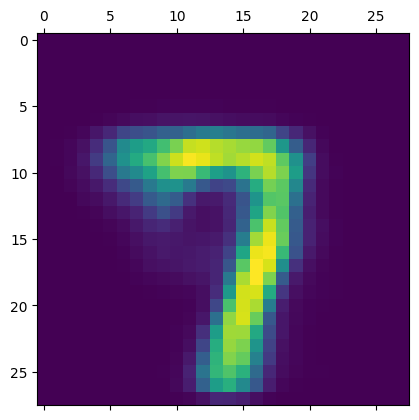

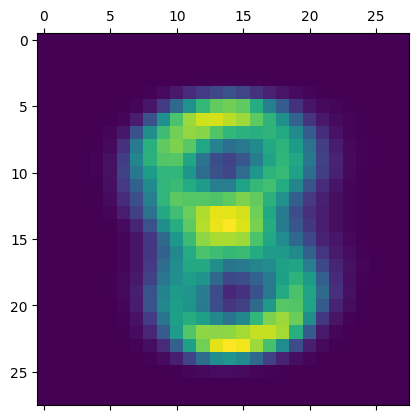

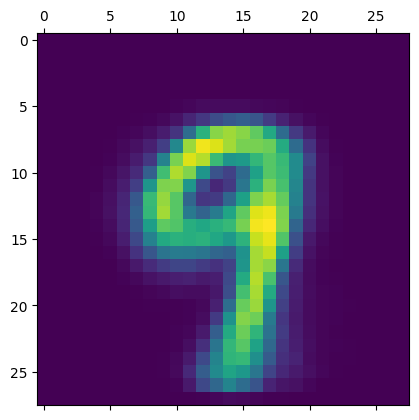

[train]epoch:9: 100%|██████████| 1875/1875 [00:06<00:00, 271.08it/s]


epoch:9|TrainLoss:  161.92917053222655


[eval]epoch:9: 100%|██████████| 313/313 [00:00<00:00, 450.16it/s]


epoch:9|Test Loss:  157.89866164550781


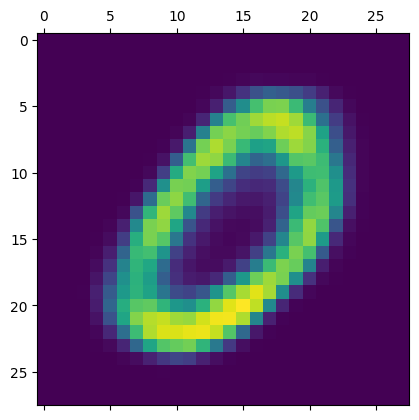

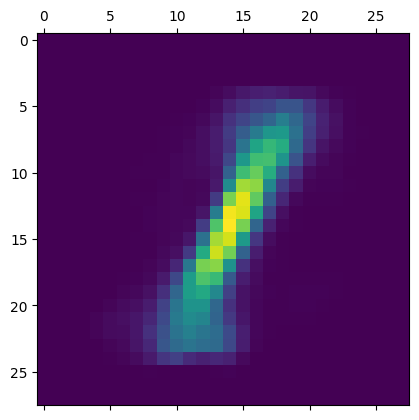

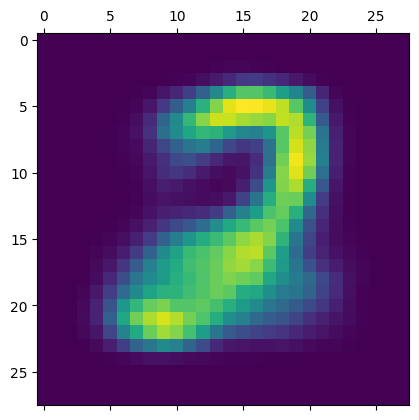

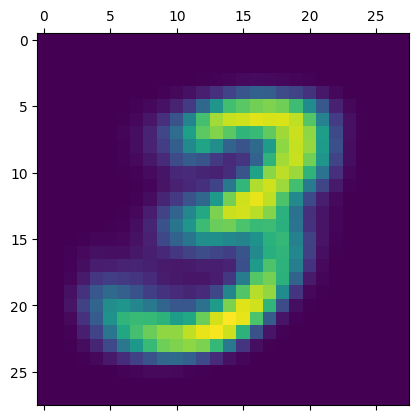

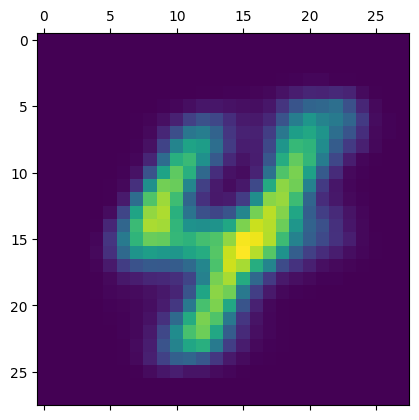

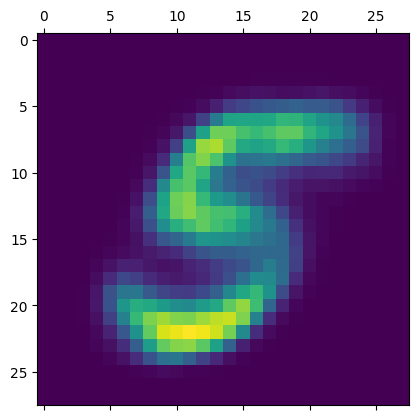

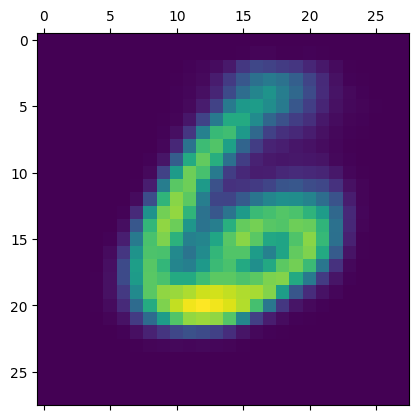

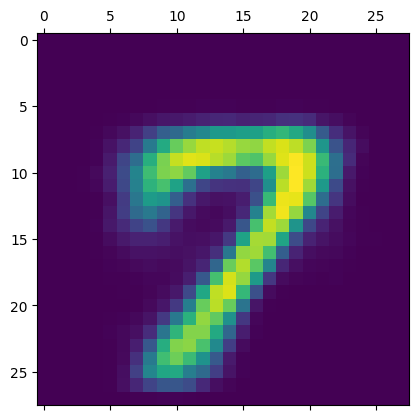

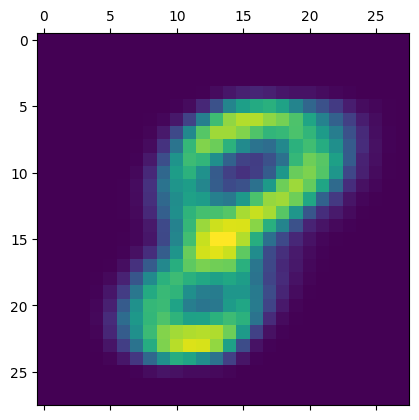

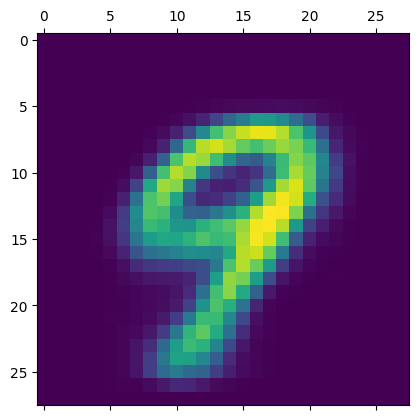

In [ ]:
for epoch in range(epochs):   
 
    train_loss = 0 # reset loss for each epoch

    for imgs, lbls in tqdm(train_loader,desc = f'[train]epoch:{epoch}'): 
        #img shape: (batch_size,1,28,28), lbls shape: (batch_size,)
        bs = imgs.shape[0]    
        imgs = imgs.view(bs,input_size).to(device) # batch_size,input_size(28*28)
        lbls = onehot(lbls.to(device),condition_size)
        
        re_imgs,mu,sigma = model(imgs,lbls)

        loss_re = loss_BCE(re_imgs, imgs) 
        loss_norm = loss_KLD(mu, sigma) 
        loss = loss_re + loss_norm    

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    print(f'epoch:{epoch}|TrainLoss: ',train_loss/len(train_loader.dataset))

    '''Model evaluation''' 
    model.eval()
   
    test_loss = 0

    for imgs, lbls in tqdm(test_loader,desc = f'[eval]epoch:{epoch}'):
        #img shape: (batch_size,28,28), lbls shape: (batch_size,)
        bs = imgs.shape[0]
        imgs = imgs.view(bs,input_size).to(device) # batch_size,input_size(28*28)
        lbls = onehot(lbls.to(device),condition_size)
        
        re_imgs,mu,sigma = model(imgs,lbls)

        loss_re = loss_BCE(re_imgs, imgs) 
        loss_norm = loss_KLD(mu, sigma) 
        loss = loss_re + loss_norm    

        test_loss += loss.item()

    print(f'epoch:{epoch}|Test Loss: ',test_loss/len(test_loader.dataset))
    model.train()   
    
    '''Display output from model trained after each epoch'''
    model.eval()
    # sample latent space vector from standard normal
    sample = torch.randn(1,latent_size).to(device)

    # generate img for each digit
    for i in range(condition_size):
        # use decoder to generate new images
        i_number = i*torch.ones(1).long().to(device)
        condit = onehot(i_number,condition_size)
        inputs = torch.cat((sample,condit),dim = 1)
        gen = model.decoder(inputs)[0].view(28,28)
        plt.matshow(gen.cpu().detach().numpy())
        plt.show()
    model.train()

    '''Save the model'''
    torch.save(model.state_dict(), modelname)

<Figure size 1500x500 with 0 Axes>

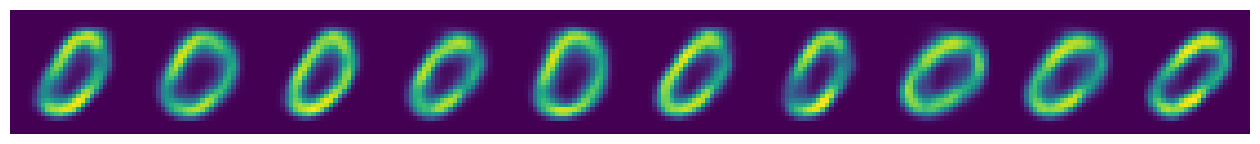

In [41]:
'''Model prediction''' 
i = 0
i_number = i * torch.ones(10).long().to(device)
condit = onehot(i_number,condition_size)

sample = torch.randn(10,latent_size).to(device)

inputs = torch.cat((sample,condit),dim = 1)

with torch.no_grad():
    gen = model.decoder(inputs).view(-1, 28, 28) 

# Concatenate all images horizontally
gen_combined = torch.cat([img for img in gen], dim=1)  # Shape: (28, 280)

plt.figure(figsize=(15, 5))
plt.matshow(gen_combined.cpu().detach().numpy())
plt.axis('off')
plt.show()